# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 


1. Tools to find best iteration of your model
1. Visualize reward distribution on the track
 - Visualize reward heatmap per episode or iteration
1. Identify hotspots on the track for your model
1. Understand probability distributions on simulated images
1. Evaluation run analysis - plot lap speed heatmap


# Predefine
Change this to your robomaker simulation job name

In [1]:
model_name="myRewardIntTest"
simulation_name = 'sim-6jlh07m20gvz'
## CHANGE This to your simulation application job name
training_job = 'dr-sm-rltj--20200705041059-a170fa35-6665-41d5-8918-c02238158a79'
#ACTIONSPACE = 21
#DIR =3
#SPEED =3
DIRs=[]
SPEEDs=[]
#TRAINING_ITERATION = 14

## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Markdown
from markdown_helper import generate_s3_write_permission_for_sagemaker_role
import sagemaker
import boto3
import shutil
import os
import glob
import math
%matplotlib inline

In [3]:
!pip install shapely

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [5]:
from log_analysis import *
from os import listdir
from os.path import isfile, join


### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [6]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::966911974471:role/service-role/AmazonSageMaker-ExecutionRole-20200424T143990


### Permission setup for Sagemaker to S3 bucket

The sagemaker wants to download simtrace from S3 bucket. This requires PutObject permission on the bucket. Make sure the sagemaker role you are using as this permissions.

In [7]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role, "AmazonSageMakerFullAccess")))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20200424T143990](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20200424T143990).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonSageMakerFullAccess` policy


### Permission setup for Sagemaker to fetch appropriate robomaker jobs

The sagemaker wants to know which robomaker simtrace job you want to download. This requires Robomaker service permission. Make sure the sagemaker role you are using as this permissions.

In [8]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role, "AWSRoboMakerFullAccess")))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20200424T143990](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20200424T143990).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AWSRoboMakerFullAccess` policy


## Download the desired log file given the simulation ID 

#### Initializing the required variables to download from S3 all the required variables

In [9]:
robomaker = boto3.client('robomaker')
sts = boto3.client("sts")
account_id = sts.get_caller_identity()['Account']
region = boto3.Session().region_name
robomaker_job_arn = "arn:aws:robomaker:{}:{}:simulation-job/{}".format(region, account_id, simulation_name)
print(robomaker_job_arn)
merged_simtrace_path = "./logs/deepracer-{}.csv".format(simulation_name)
if os.path.exists(merged_simtrace_path):
    os.remove(merged_simtrace_path)
if not os.path.exists('./logs'):
    os.mkdir('./logs')
shutil.rmtree('./tmp') if os.path.exists('./tmp') else os.mkdir('./tmp')

arn:aws:robomaker:us-east-1:966911974471:simulation-job/sim-6jlh07m20gvz


In [10]:
# Get all the infro
job_desc = robomaker.describe_simulation_job(job=robomaker_job_arn)
#check with https://jsonformatter.curiousconcept.com/
#print(job_desc)

is_training = job_desc['simulationApplications'][0]['launchConfig']['launchFile'] == "distributed_training.launch"
s3_bucket = job_desc['simulationApplications'][0]['launchConfig']['environmentVariables']['METRICS_S3_BUCKET']
print(s3_bucket)

aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d


### Download training-simtrace from S3
#### There is only the most recent training log kept in the S3 bucket
#### New training will replace the log of preivous training 

In [11]:
simtrace_path="s3://{}/{}/training-simtrace/".format(s3_bucket,s3_bucket)
# Downlaod all the simtrace iteration data
!aws s3 sync {simtrace_path} ./tmp 


download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/0-iteration.csv to tmp/0-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/1-iteration.csv to tmp/1-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/100-iteration.csv to tmp/100-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/104-iteration.csv to tmp/104-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/107-iteration.csv to tmp/107-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/t

download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/147-iteration.csv to tmp/147-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/150-iteration.csv to tmp/150-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/141-iteration.csv to tmp/141-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/154-iteration.csv to tmp/154-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/153-iteration.csv to tmp/153-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f

download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/2-iteration.csv to tmp/2-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/22-iteration.csv to tmp/22-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/172-iteration.csv to tmp/172-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/21-iteration.csv to tmp/21-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/24-iteration.csv to tmp/24-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/tra

download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/67-iteration.csv to tmp/67-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/69-iteration.csv to tmp/69-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/66-iteration.csv to tmp/66-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/70-iteration.csv to tmp/70-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/training-simtrace/68-iteration.csv to tmp/68-iteration.csv
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/tra

In [12]:
from functools import reduce

def getSpeedDirs(n):  #buggy  
    f=list(set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0))))
    #print(f)
    f.sort()
    #print(f)
    if len(f)==1:
        speed=1
        dirs=1
    elif len(f)==2:
        speed=1
        dirs=n
    elif len(f)==3:
        speed=f[1]
        dirs=f[1]
    else:
        speed=f[1]
        dirs=f[2]
    return speed, dirs

def getActionCount(model_name, s3_bucket):
    import boto3
    import json
    s3 = boto3.resource('s3')
    my_bucket = s3.Bucket(s3_bucket)
    targetModel=""
    actCount=0
    DIRs=[]
    SPEEDs=[]

    for my_bucket_object in my_bucket.objects.filter(Prefix='model-metadata'):
        if model_name in my_bucket_object.key: 
            #print(my_bucket_object.key)
            #print(my_bucket_object)
            body = my_bucket_object.get()['Body'].read().decode('utf-8')
            #print(body)
            s3clientlist=json.loads(body)
            #print("json loaded data")
            actCount=len(s3clientlist['action_space'])
            for ii in range(actCount):
                print(s3clientlist['action_space'][ii])
                print(s3clientlist['action_space'][ii]['steering_angle'])
                DIRs.append(s3clientlist['action_space'][ii]['steering_angle'])
                SPEEDs.append(s3clientlist['action_space'][ii]['speed'])
            
            #print(type(s3clientlist))
            break

    return actCount,DIRs,SPEEDs

#actCount=getActionCount(model_name, s3_bucket)      
#print(actCount)
ACTIONSPACE,DIRs,SPEEDs=getActionCount(model_name, s3_bucket) 
SPEED,DIR=getSpeedDirs(ACTIONSPACE)
print(DIRs)
print(SPEEDs)
#print(ACTIONSPACE)
#for ii in range(1,22):
#    print(ii)
#    print(getSpeedDirs(ii))

{'steering_angle': -30, 'speed': 0.3333333333333333, 'index': 0}
-30
{'steering_angle': -30, 'speed': 0.6666666666666666, 'index': 1}
-30
{'steering_angle': -30, 'speed': 1, 'index': 2}
-30
{'steering_angle': 0, 'speed': 0.3333333333333333, 'index': 3}
0
{'steering_angle': 0, 'speed': 0.6666666666666666, 'index': 4}
0
{'steering_angle': 0, 'speed': 1, 'index': 5}
0
{'steering_angle': 30, 'speed': 0.3333333333333333, 'index': 6}
30
{'steering_angle': 30, 'speed': 0.6666666666666666, 'index': 7}
30
{'steering_angle': 30, 'speed': 1, 'index': 8}
30
[-30, -30, -30, 0, 0, 0, 30, 30, 30]
[0.3333333333333333, 0.6666666666666666, 1, 0.3333333333333333, 0.6666666666666666, 1, 0.3333333333333333, 0.6666666666666666, 1]


#### Merge all the csv files into one big .csv file

In [13]:
import pandas as pd


def get_sort_csv_file():
    sim_trace_csvs = glob.glob("./tmp/*.csv")
    csvs_with_ids = [(int(os.path.basename(file).split("-")[0]), file) for file in sim_trace_csvs]
    csvs_sorted = sorted(csvs_with_ids, key=lambda csvs_with_ids: csvs_with_ids[0])
    return [csv_file[1] for csv_file in csvs_sorted]

def tStamp(csvFile):
    df = pd.read_csv(csvFile) 
    df_tstamp=df.iloc[0]['tstamp']
    return df_tstamp

    
def merge_csv_files(output_file_path):
    csv_files = get_sort_csv_file()
    header_saved = False
    headCSV='./tmp/0-iteration.csv'

    df0_tstamp=tStamp(headCSV)
    print(df0_tstamp)
    count=0

    
    with open(output_file_path, 'w') as fout:
        for csv_file in csv_files:
            #print(csv_file)
            df_tstamp=tStamp(csv_file)
            #print(df_tstamp)
            #print(df_tstamp >= df0_tstamp)

            if (df_tstamp >= df0_tstamp):
                count=count+1
                with open(csv_file) as fin:
                    header = next(fin)
                    if not header_saved:
                        fout.write(header)
                        header_saved = True
                    for line in fin:
                        fout.write(line)

    print("iteration count="+ str(count))
    return count
TRAINING_ITERATION=merge_csv_files(merged_simtrace_path)
!tail -n 3 $merged_simtrace_path

1593922510.2117019
iteration count=14
279,201.0,5.634732185177597,3.136827231890489,141.61560857106525,30.0,1.0,8,0.001,False,False,45.63372870199753,28,17.671677230923088,1593925746.0379603,in_progress
279,202.0,5.581878286562888,3.1818952740152335,140.8668143338894,0.0,1.0,5,0.001,False,False,45.93064662390598,28,17.671677230923088,1593925746.105417,in_progress
279,203.0,5.531743288193519,3.2246705180581277,140.37013958060413,-30.0,0.3333333333333333,0,0.001,True,False,46.21228932439529,28,17.671677230923088,1593925746.1743705,off_track


## Load waypoints for the track you want to run analysis on


In [14]:
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
print(ListFiles)

['AWS_track.npy', 'ChampionshipCup2019_track.npy', 'H_track.npy', 'Oval_track.npy', 'New_York_Track.npy', 'Bowtie_track.npy', 'Tokyo_Training_track.npy', 'reInvent2019_wide_mirrored.npy', 'Mexico_track.npy', 'Vegas_track.npy', 'reinvent_base.npy', 'reInvent2019_wide.npy', 'China_track.npy', 'London_Loop_Train.npy', 'reInvent2019_track.npy', 'Straight_track.npy', 'Virtual_May19_Train_track.npy', 'Canada_Training.npy']


In [15]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)
    
waypoints = get_track_waypoints("reinvent_base") ### re:invent track
waypoints.shape

(71, 6)

## Visualize the Track and Waypoints

In [16]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

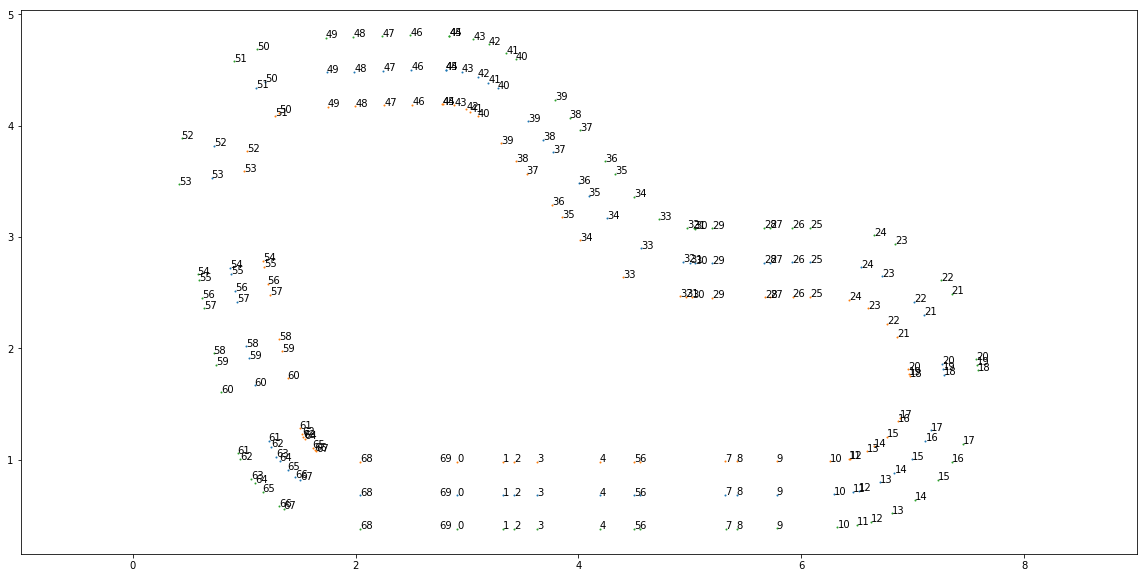

In [17]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

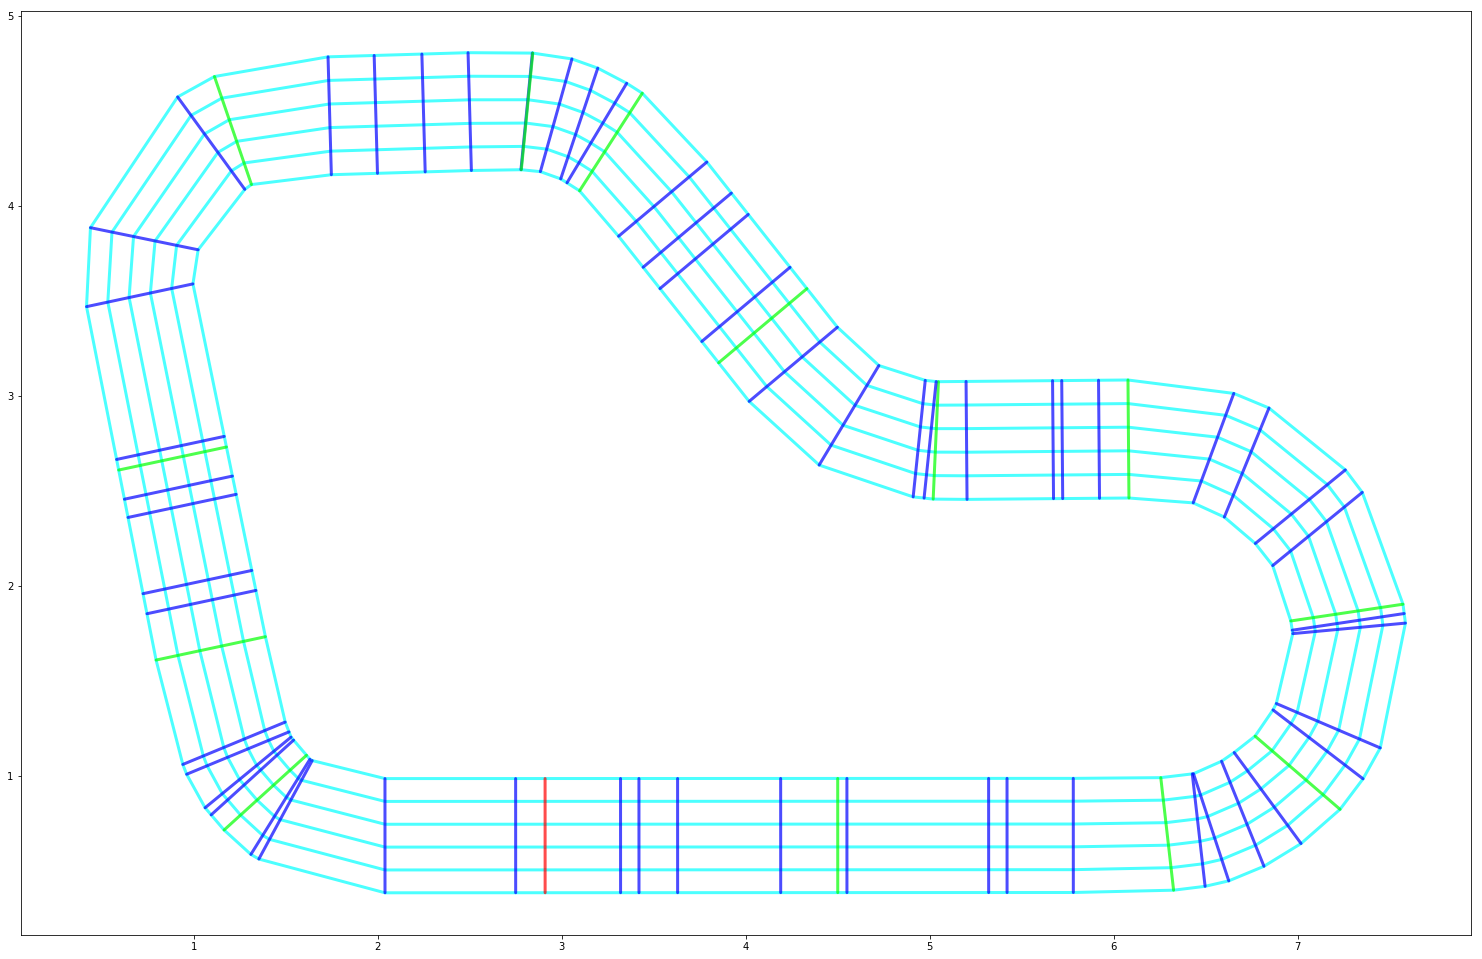

In [18]:
def plot_line(ax, ob, color='cyan'):
    x, y = ob.xy
    ax.plot(x, y, color, alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

l_center_line = LineString(waypoints[:,0:3])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
#for ii in range(71):
    
fig, ax = plt.subplots(figsize=(26,17))
#plot_coords(ax, l_inner_border)
plot_line(ax, l_inner_border)
#plot_coords(ax, l_outer_border)
plot_line(ax, l_outer_border)
plot_line(ax, LineString(waypoints[:,2:4]*0.2+waypoints[:,4:6]*0.8))
plot_line(ax, LineString(waypoints[:,2:4]*0.4+waypoints[:,4:6]*0.6))
plot_line(ax, LineString(waypoints[:,2:4]*0.6+waypoints[:,4:6]*0.4))
plot_line(ax, LineString(waypoints[:,2:4]*0.8+waypoints[:,4:6]*0.2))
for ii in range(70):
    if ii==0:
        myColor='#ff0000'
    elif (ii%5)==0:
        myColor='#00ff00'  
    else:
        myColor='#0000ff'  
    plot_line(ax, LineString([waypoints[ii,2:4],waypoints[ii,4:6]]),color=myColor)
#plot_line(ax, LineString([waypoints[0,2:4],waypoints[0,4:6]]),color='#ff0000')



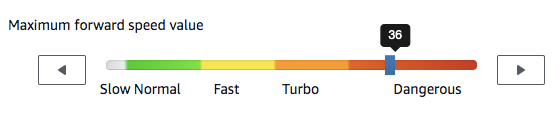

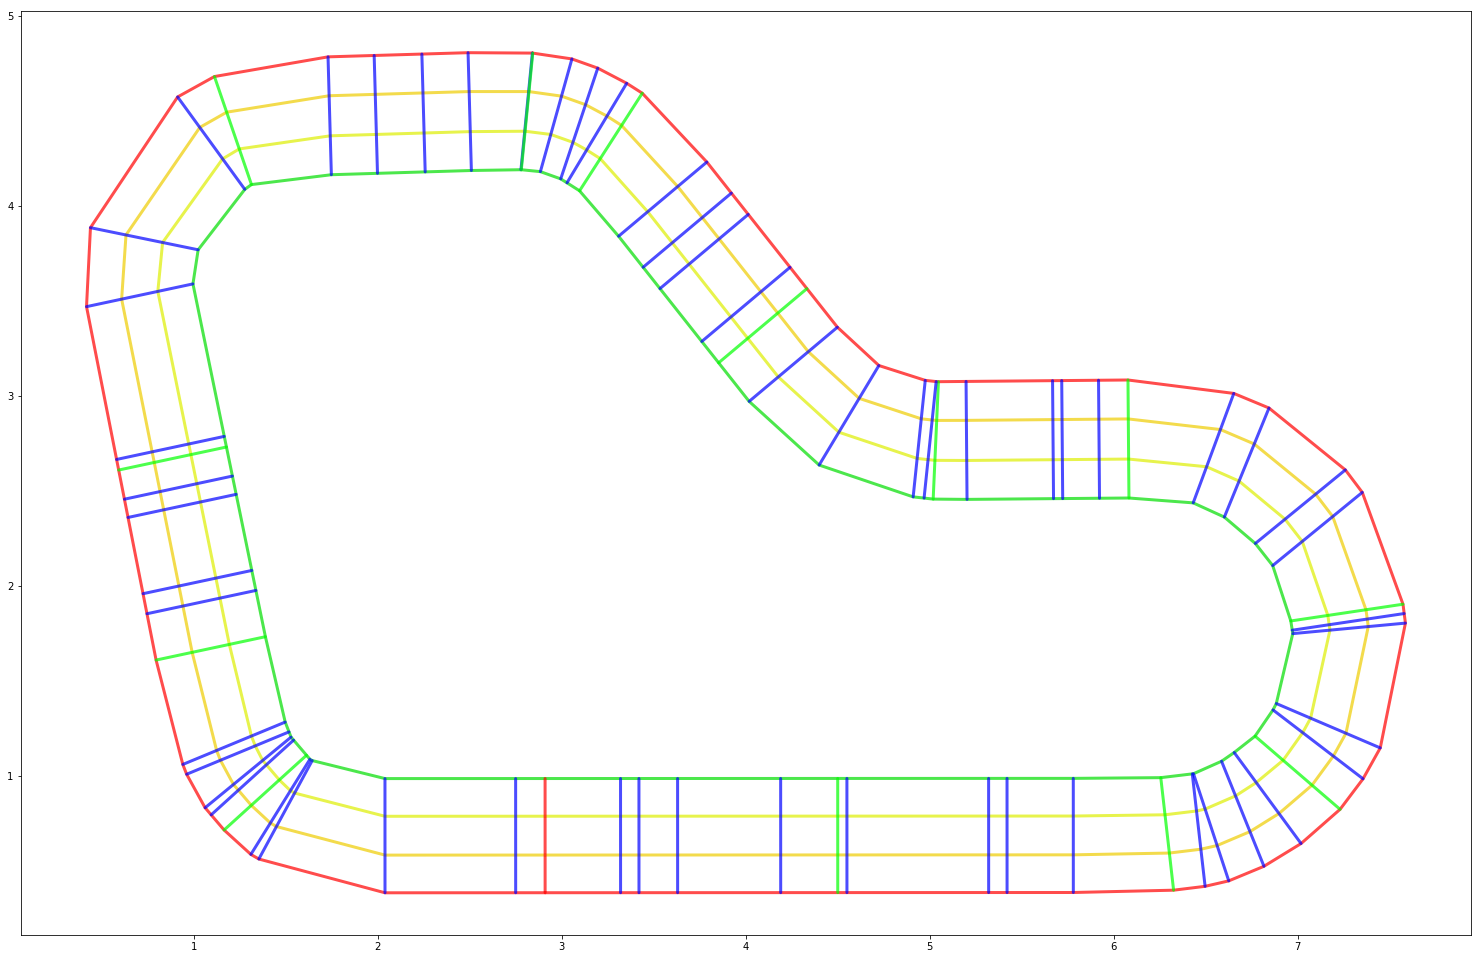

In [19]:
def plot_line(ax, ob, color='cyan'):
    x, y = ob.xy
    ax.plot(x, y, color, alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

l_center_line = LineString(waypoints[:,0:3])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
#for ii in range(71):
    
fig, ax = plt.subplots(figsize=(26,17))
#plot_coords(ax, l_inner_border)
plot_line(ax, l_inner_border, color='#00dd00')
#plot_coords(ax, l_outer_border)
plot_line(ax, l_outer_border, color='#ff0000')
plot_line(ax, LineString(waypoints[:,2:4]*0.33+waypoints[:,4:6]*0.67), color='#eecc00')
plot_line(ax, LineString(waypoints[:,2:4]*0.67+waypoints[:,4:6]*0.33), color='#ddee00')
#plot_line(ax, LineString(waypoints[:,2:4]*0.6+waypoints[:,4:6]*0.4))
#plot_line(ax, LineString(waypoints[:,2:4]*0.8+waypoints[:,4:6]*0.2))
for ii in range(70):
    if ii==0:
        myColor='#ff0000'
    elif (ii%5)==0:
        myColor='#00ff00'  
    else:
        myColor='#0000ff'  
    plot_line(ax, LineString([waypoints[ii,2:4],waypoints[ii,4:6]]),color=myColor)


In [20]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Helper Functions 

In [21]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"] + x_offset)
        y = int(row["y"] + y_offset)
        reward = row["reward"]
        track[y, x] = reward
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return track

In [22]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(18, 5))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(1,n_laps,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

## Load the training log

In [23]:
df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(df.episode.max()/TRAINING_ITERATION)+1) * TRAINING_ITERATION
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,iteration
0,0,1.0,3.050077,0.683240,0.022161,0.0,0.333333,3,1.0,False,True,0.792693,0,17.671677,1.593923e+09,in_progress,1
1,0,2.0,3.053619,0.683259,0.031119,30.0,0.666667,7,1.0,False,True,0.812733,0,17.671677,1.593923e+09,in_progress,1
2,0,3.0,3.059606,0.683403,0.090382,0.0,1.000000,5,1.0,False,True,0.846613,0,17.671677,1.593923e+09,in_progress,1
3,0,4.0,3.089665,0.684170,0.368365,30.0,1.000000,8,1.0,False,True,1.016712,0,17.671677,1.593923e+09,in_progress,1
4,0,5.0,3.129628,0.686556,1.113811,0.0,1.000000,5,1.0,False,True,1.242856,1,17.671677,1.593923e+09,in_progress,1


In [24]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())


## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  279


Text(0.5, 0, 'Episode')

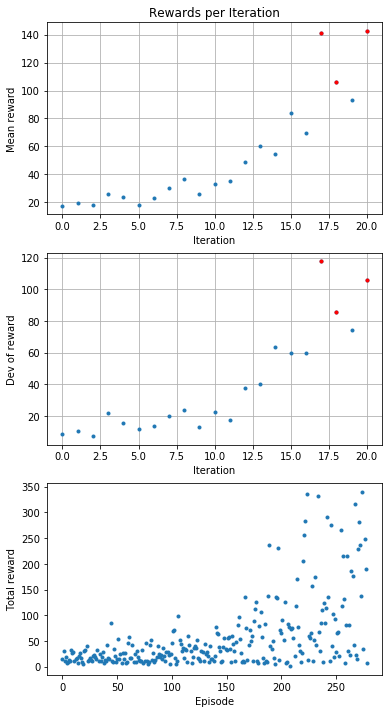

In [25]:
REWARD_THRESHOLD = 100

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == TRAINING_ITERATION - 1:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

## Analyze the reward distribution for your reward function

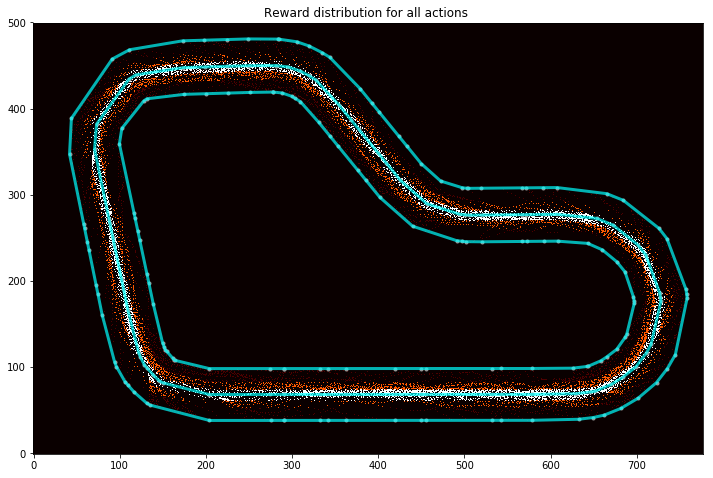

In [26]:
def plot_track_reward(df, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"]*100 + x_offset)
        y = int(row["y"]*100 + y_offset)
        reward = row["reward"]
        track[y, x] = reward
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line*100, inner_border*100, outer_border*100)
    return track


track_size_x=int(df['x'].max()*100)+1
track_size_y=int(df['y'].max()*100)+1
track = plot_track_reward(df, track_size=(track_size_y, track_size_x), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='nearest', origin="lower") 

### Plot a particular iteration


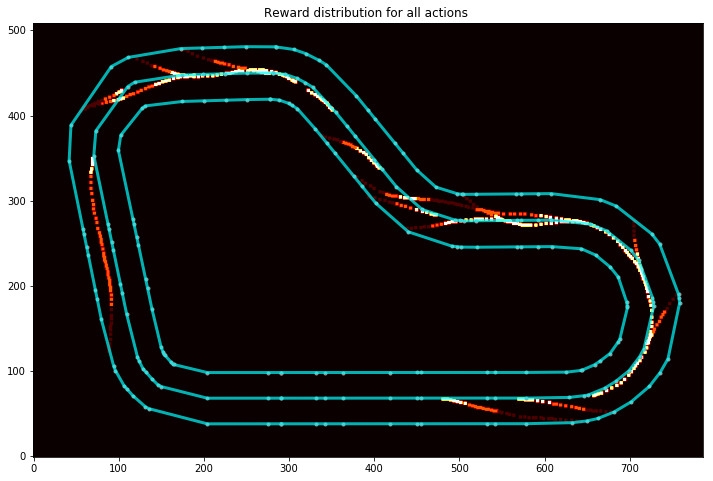

In [27]:
def plot_track_reward_one(df, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"]*100 + x_offset)
        y = int(row["y"]*100 + y_offset)
        reward = row["reward"]
        track[y-2:y+2, x-2:x+2] = reward
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line*100, inner_border*100, outer_border*100)
    return track



iteration_id = 4
track_size_x=int(df['x'].max()*100)+10
track_size_y=int(df['y'].max()*100)+10
track = plot_track_reward_one(df[df['iteration'] == iteration_id], track_size=(track_size_y, track_size_x), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

The top 3 highest reward episodes are [274, 223, 233]


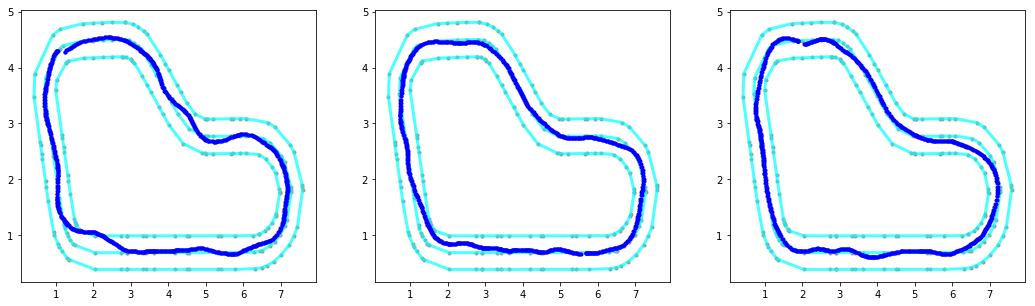

In [28]:
action_map, episode_map, sorted_idx = episode_parser(df)    
fig = plot_top_laps(sorted_idx[:], 3)
print("The top 3 highest reward episodes are {}".format(sorted_idx[:3]))

### Path taken in a particular episode

In [29]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

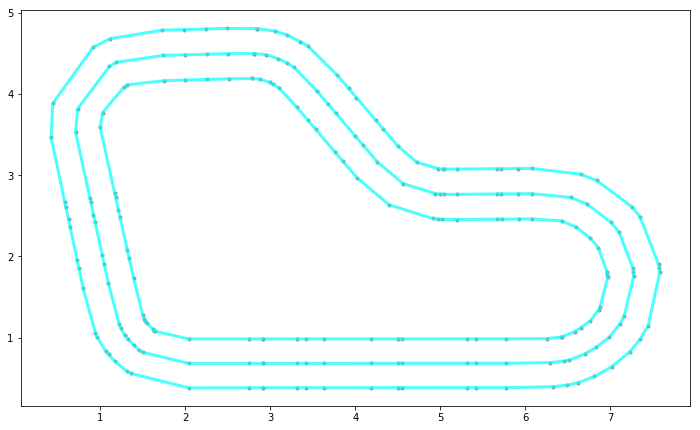

In [30]:
plot_episode_run(df, E=1200) # arbitrary episode

### Path taken in a particular Iteration

20


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


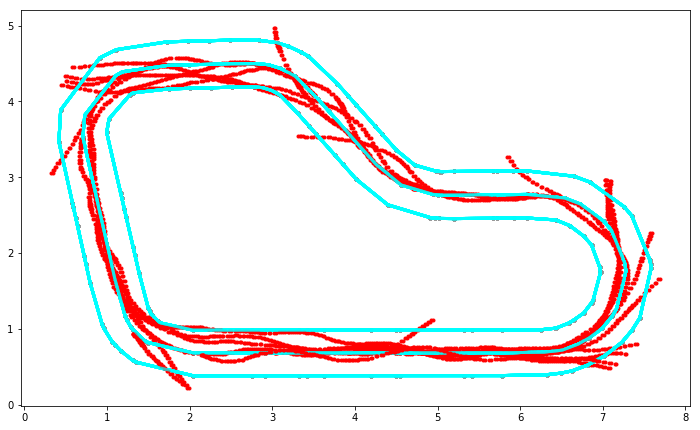

In [31]:
iteration_id = 10
print(EPISODE_PER_ITER)

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, E=i)

## Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration.

** NOTE: This is only supported for reinvent track currently **

Number of steps in iteration= 576


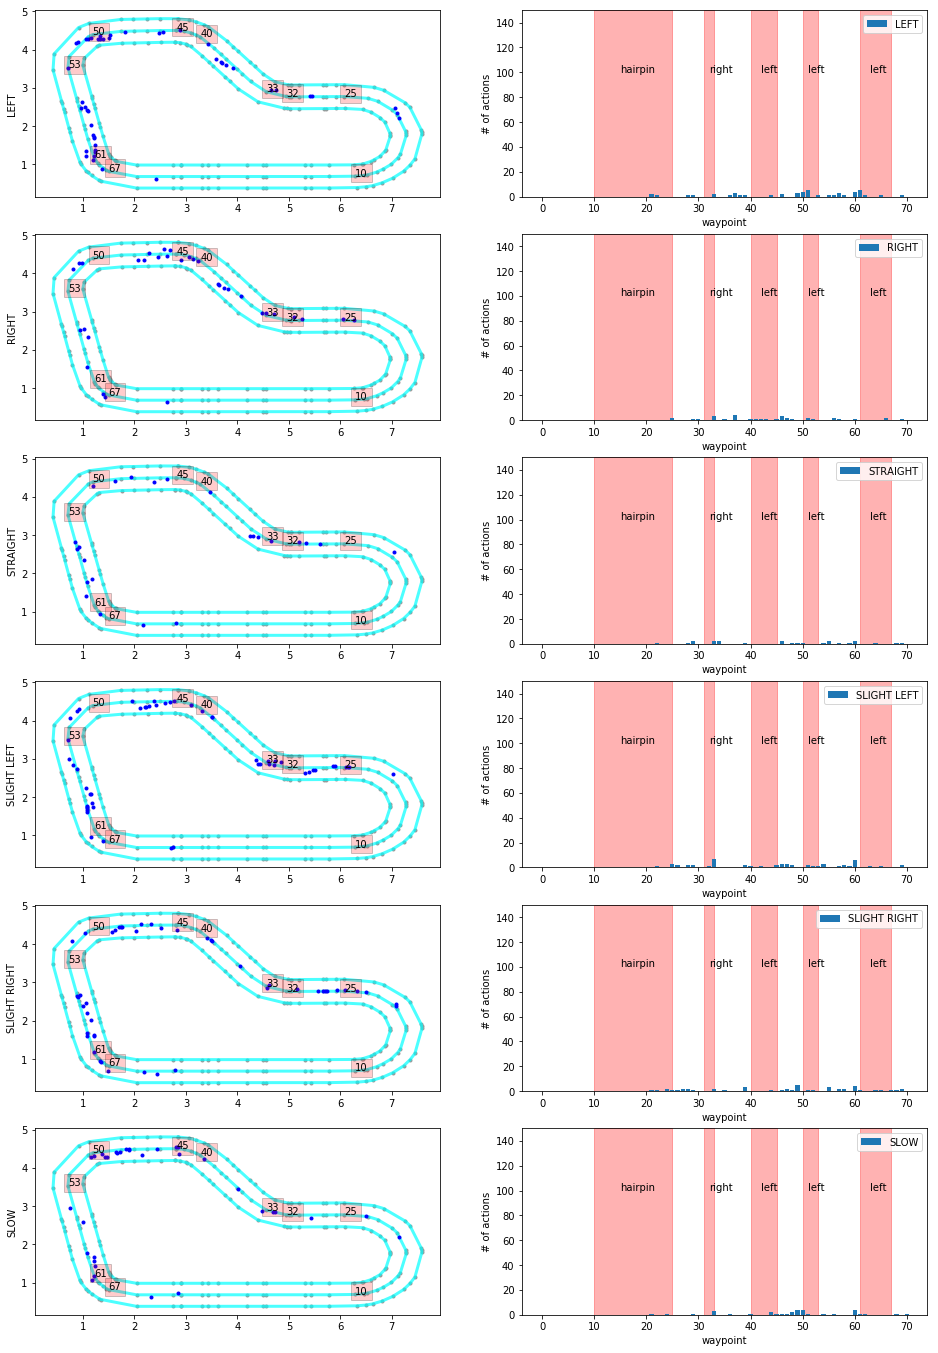

In [32]:
fig = plt.figure(figsize=(16, 24))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

# Track Segment Labels
action_names = ['LEFT', 'RIGHT', 'STRAIGHT', 'SLIGHT LEFT', 'SLIGHT RIGHT', 'SLOW']
vert_lines = [10,25,32,33,40,45,50,53,61,67]
track_segments = [(15, 100, 'hairpin'),
                  (32, 100, 'right'),
                  (42, 100, 'left'),
                  (51, 100, 'left'),
                  (63, 100, 'left')]

segment_x = np.array([15, 32, 42, 51, 63])
segment_y = np.array([0, 0, 0, 0, 0])

segment_xerr = np.array([[5, 1, 2, 1, 2], [10, 1, 3, 2, 4]])
segment_yerr = np.array([[0, 0, 0, 0, 0], [150, 150, 150, 150, 150]])

wpts_array = center_line 
th = 0.1

for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)
    for idx in range(len(action_names)):
        ax = fig.add_subplot(6, 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in vert_lines:
            ax.text(wpts_array[idWp][0], wpts_array[idWp][1], str(idWp), bbox=dict(facecolor='red', alpha=0.2))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        #print(df_slice['closest_waypoint'])
        for idWp in range(len(wpts_array)):
            #print(idWp)
            act=len(df_slice[df_slice['closest_waypoint'] == idWp])
            action_waypoint_distribution.append(act)

        ax = fig.add_subplot(6, 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)

        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], track_segments[tt][1], track_segments[tt][2])

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, 150))

Lets analyze the hairpin turn for the best iteration. We see that the model like to take Slight left and Straight over other actions, we see that slight right and right actions frequency is very low in comparison. In short, this model seems to do well for the hairpin turn 

## Simulation Image Analysis - Probability distribution on decisions (actions)

is the model making decisions that are "too close" or is it confident for the laps it finishes. if the top and second best decisions are far apart, the model must likely be making more confident decisions 

## Download  the model (provided as an example).  
### We recommend downloading only the ones you are interested in
### You have to specify the path of model ,  the prefix is DeepRacer-SageMaker-rlmdl  and the latest directory is what you want


In [33]:
#training_job parsing

x=training_job.split('-')
# x[4] is datetime stamp
datetime_stamp=x[4]

import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(s3_bucket)
targetModel=""

#for my_bucket_object in my_bucket.objects.all():
for my_bucket_object in my_bucket.objects.filter(Prefix='DeepRacer-SageMaker-rlmdl-'):
    if datetime_stamp in my_bucket_object.key: 
        print(my_bucket_object.key)
        targetModel=my_bucket_object.key
        
    
    
modelPath="s3://{}/".format(s3_bucket)
modelPath=modelPath+targetModel
#modelPath=modelPath+"DeepRacer-SageMaker-rlmdl-966911974471-20200612075651-dcffe9b4-a98c-447c-992b-09e0b358a97d/"
#modelPath=modelPath+"dr-sm-rltj--20200612075652-411481de-7465-4ad2-bea9-8162fe1b7fd0/"
#modelPath=modelPath+"output/model.tar.gz"
!aws s3 cp {modelPath} "./"

DeepRacer-SageMaker-rlmdl-966911974471-20200705041059-21b3ad16-6b22-4dc7-a670-7f51a02f0808/dr-sm-rltj--20200705041059-a170fa35-6665-41d5-8918-c02238158a79/output/model.tar.gz
download: s3://aws-deepracer-989e6911-e7d3-49a4-9770-9d9f7f26f28d/DeepRacer-SageMaker-rlmdl-966911974471-20200705041059-21b3ad16-6b22-4dc7-a670-7f51a02f0808/dr-sm-rltj--20200705041059-a170fa35-6665-41d5-8918-c02238158a79/output/model.tar.gz to ./model.tar.gz


In [34]:
!tar -xzvf ./model.tar.gz

model_metadata.json
agent/
agent/model.pb
worker_0.multi_agent_graph_0.json
worker_0.multi_agent_graph.main_level.main_level.agent_0.csv


In [35]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

GRAPH_PB_PATH = 'intermediate_checkpoint/'

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)
    
    # Different tensor names observation, 'FRONT_FACING_CAMERA', 'STEREO_CAMERAS'
    # For stereo cameras use the below
    # x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/STEREO_CAMERAS/STEREO_CAMERAS:0')
    # y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    # For front cameras use the below
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/FRONT_FACING_CAMERA/FRONT_FACING_CAMERA:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


model_inference = []
iterations = [1]

for ii in iterations:
    model, obs, model_out = load_session('agent/model.pb')
    arr = []
    for f in all_files[:]:
        img = Image.open(f)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        #print(y_output)
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.reset_default_graph()


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: agent/model.pb
Instructions for updating:
Use tf.gfile.GFile.


model appears to have a better seperation in probabability, hence may work better in sim2real experiments

1
917


(array([386., 183., 106.,  59.,  59.,  50.,  28.,  21.,  15.,  10.]),
 array([1.0076165e-04, 8.9352690e-02, 1.7860462e-01, 2.6785654e-01,
        3.5710847e-01, 4.4636041e-01, 5.3561234e-01, 6.2486422e-01,
        7.1411616e-01, 8.0336809e-01, 8.9262003e-01], dtype=float32),
 <a list of 10 Patch objects>)

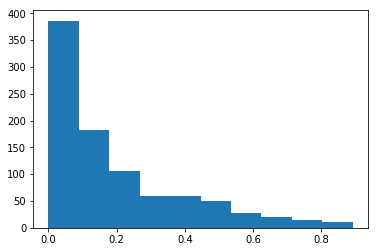

In [36]:
prob_diff = []
print(len(model_inference))
print(len(model_inference[0]))
for mi in model_inference[0]:
    #print(mi)
    max1, max2 = mi.argsort()[-2:][::-1]
    #print(max1, max2)
    prob_diff.append(mi[max1] - mi[max2])
plt.hist(prob_diff)

# Model CSV Analysis


Download the model from the console AWS DeepRacer > Reinforcement learning > $Training Job Name$ > Download Model


In [37]:
fname = 'worker_0.multi_agent_graph.main_level.main_level.agent_0.csv'
df_csv = pd.read_csv(fname)

In [38]:
df_csv.columns

Index(['Episode #', 'Training Iter', 'Epoch', 'In Heatup', 'ER #Transitions',
       'ER #Episodes', 'Episode Length', 'Total steps', 'Epsilon',
       'Shaped Training Reward', 'Training Reward', 'Update Target Network',
       'Wall-Clock Time', 'Evaluation Reward', 'Shaped Evaluation Reward',
       'Success Rate', 'Inverse Propensity Score', 'Direct Method Reward',
       'Doubly Robust', 'Weighted Importance Sampling',
       'Sequential Doubly Robust', 'Loss/Mean', 'Loss/Stdev', 'Loss/Max',
       'Loss/Min', 'Learning Rate/Mean', 'Learning Rate/Stdev',
       'Learning Rate/Max', 'Learning Rate/Min', 'Grads (unclipped)/Mean',
       'Grads (unclipped)/Stdev', 'Grads (unclipped)/Max',
       'Grads (unclipped)/Min', 'Discounted Return/Mean',
       'Discounted Return/Stdev', 'Discounted Return/Max',
       'Discounted Return/Min', 'Entropy/Mean', 'Entropy/Stdev', 'Entropy/Max',
       'Entropy/Min', 'Advantages/Mean', 'Advantages/Stdev', 'Advantages/Max',
       'Advantages/Min',

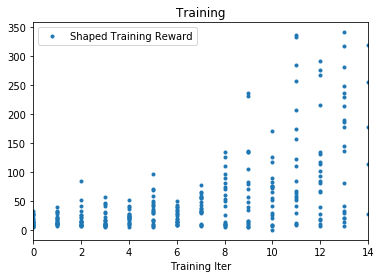

In [39]:
title = "Training"
df_csv.plot(x='Training Iter', y='Shaped Training Reward', style='.', 
        title=title)

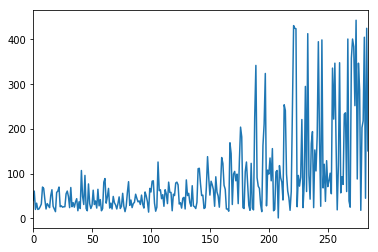

In [40]:
df_csv['Episode Length'].plot()

## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [67]:
import cv2
import numpy as np
import tensorflow as tf

def visualize_gradcam_discrete_ppo(sess, rgb_img, category_index=0, num_of_actions=5):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    
    img_arr = np.array(rgb_img)
    img_arr = rgb2gray(img_arr)
    #plt.imshow(img_arr)
    #plt.show()
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/FRONT_FACING_CAMERA/FRONT_FACING_CAMERA:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    feed_dict = {x:[img_arr]}
    

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    
    reduced_loss = tf.reduce_sum(loss[0])
    
    # For front cameras use the below
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_4/Conv2D:0')
    
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / (np.max(cam)+1E-5) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

In [42]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

### num_of_actions=21 is depend on your model

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: agent/model.pb
9


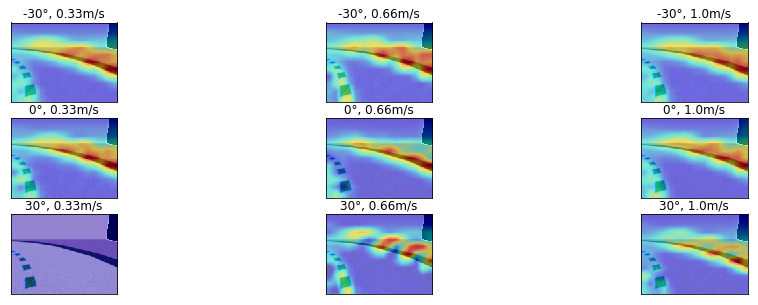

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: agent/model.pb
9


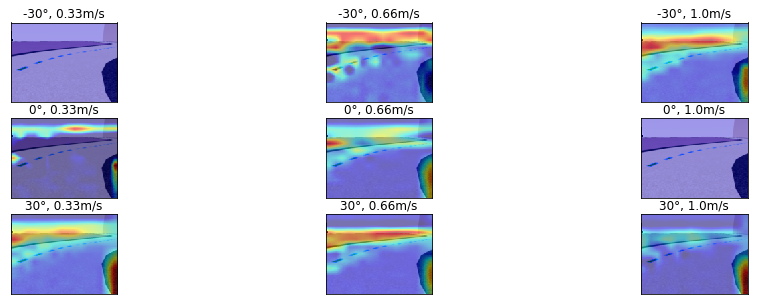

In [72]:
def getHeat(f):
    model_path = 'agent/model.pb' #Change this to your model 'pb' frozen graph file
    model, obs, model_out = load_session(model_path)

    heatmaps = []
    img_matthew = np.array(Image.open(f))
    #plt.imshow(img_matthew)
    #plt.show()
    for idx in range(ACTIONSPACE):
        heatmap = visualize_gradcam_discrete_ppo(model, img_matthew, category_index=idx, num_of_actions=ACTIONSPACE)
        heatmaps.append(heatmap)

    fig = plt.figure(figsize=(16, 5))
    print(len(heatmaps))
    for i in range(len(heatmaps)):
        ii=i+1
        iModSPEED=i%SPEED
        iDivSPEED=int(i/SPEED)
        j=iModSPEED*7+iDivSPEED
        ax = fig.add_subplot(SPEED,DIR , i+1)
        #ax.set_title(action_names[i], fontsize=8)
        ax.tick_params(labelbottom=False, labelleft=False)
        plt.xticks([])
        plt.yticks([])
        ax.imshow(heatmaps[i])
        plt.title(str(DIRs[i])+'°, '+str(float(int(SPEEDs[i]*100)/100))+'m/s')
    plt.show()
    tf.reset_default_graph()

getHeat('simulation_episode/sim-image-3-00000.png')
getHeat('simulation_episode/sim-image-3-00173.png')